# Loading dataset..

In [1]:
! pip install datasets 
! pip install rank_bm25
! pip install -U pip setuptools wheel
! pip install -U spacy
! python -m spacy download en_core_web_sm
! pip install itables
! pip install transformers
! pip install torchmetrics
! pip install SentencePiece
!pip install transformers==2.2.0
!pip install bert-extractive-summarizer
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [2]:
! wget -P /content/ http://nlp.stanford.edu/data/glove.6B.zip
! unzip /content/glove.6B.zip
! rm glove.6B.100d.txt glove.6B.200d.txt glove.6B.50d.txt glove.6B.zip

--2023-04-26 11:26:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-26 11:26:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-26 11:26:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/glove.6B.z

In [3]:
from datasets import list_datasets, load_dataset
from pprint import pprint
import os
import json
import pandas as pd 
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from rank_bm25 import BM25Okapi
from pprint import pprint
import numpy as np
from numpy.linalg import norm
from numpy import size, nan
from random import randrange
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from transformers import PreTrainedTokenizer, T5ForConditionalGeneration, T5Tokenizer, AdamW
from tqdm import tqdm
from collections import Counter
from summarizer import Summarizer,TransformerSummarizer
from summarizer.sbert import SBertSummarizer
import torch
from torch.utils.data import Dataset, DataLoader
from torchmetrics.text.rouge import ROUGEScore
nlp = spacy.load("en_core_web_sm")

In [ ]:
# here I download the 2 text summarization models that in the end I will compare
bert_model = Summarizer()
gpt2_model = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2-medium")

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
dataset = load_dataset('narrativeqa') 

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/32747 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10557 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3461 [00:00<?, ? examples/s]

Dataset narrativeqa downloaded and prepared to /root/.cache/huggingface/datasets/narrativeqa/default/0.0.0/daef7ccc51ec258bef464658d11751bb20f033da9b4c219fd84563b3a4af0422. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In this image is showed how the Hugging Face Narrative QA dataset is structured:

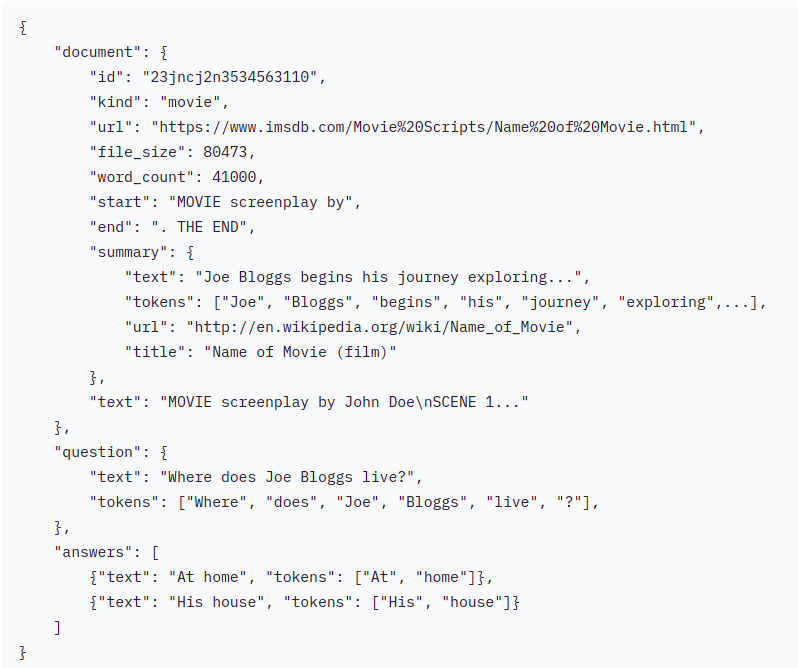

In [ ]:
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']
pprint(train_ds)
pprint(val_ds)
pprint(test_ds)

Dataset({
    features: ['document', 'question', 'answers'],
    num_rows: 32747
})
Dataset({
    features: ['document', 'question', 'answers'],
    num_rows: 3461
})
Dataset({
    features: ['document', 'question', 'answers'],
    num_rows: 10557
})


- Here I will save in some json files the training set, the validation set and the test set (only the fields I need)..
- the start_cut and the end_cut values for cutting the full texts setting on Narrative QA dataset are set manually

In [ ]:
# TRAINING SET 
start_cut = 496
end_cut = 18422
train_data = []
n=0
for i in train_ds:
  if n < 10000:
    if i['document']['kind'] == "gutenberg":
      id = i['document']['id']                                    # unique ID for the story
      text = i['document']['text'][start_cut:end_cut]             # complete text
      summary = i['document']['summary']['text']                  # summary
      quest = i['question']
      ans = i['answers']
      train_data.append({'id': id, 'text': text, 'summary': summary, 'quest': quest, 'ans': ans})
      n+=1

json.dump(train_data, open('/content/train_data.json', 'a+'))

# VALIDATION SET 
val_data = []
n=0
title_summ1_dict = {}
title_summ2_dict = {}
for i in val_ds:
  if n < 2000:
    if i['document']['kind'] == "gutenberg":
      id = i['document']['id']                                      
      summary = i['document']['summary']['text']                    
      quest = i['question']
      ans = i['answers']

      title = i['document']['summary']['title']
      if title in title_summ1_dict:
        bert_summary = title_summ1_dict[title]
        gpt2_summary = title_summ2_dict[title]
      else:
        full_text = i['document']['text'][start_cut:end_cut]              
        # APPLICATION MODEL1: BERT
        bert_summary = ''.join(bert_model(full_text, max_length=320))
        # APPLICATION MODEL2: GPT2
        gpt2_summary = ''.join(gpt2_model(full_text, max_length=320))
        title_summ1_dict[title] = bert_summary
        title_summ2_dict[title] = gpt2_summary

      val_data.append({'id': id, 'model1': bert_summary, 'model2': gpt2_summary, 'summary': summary, 'quest': quest, 'ans': ans})
      n+=1

json.dump(val_data, open('/content/val_data.json', 'a+'))

# TEST SET
test_data = []
n=0
title_summ1_dict = {}
title_summ2_dict = {}
for i in test_ds:
  if n < 5000:
    if i['document']['kind'] == "gutenberg":
      id = i['document']['id']                                      
      summary = i['document']['summary']['text']                    
      quest = i['question']
      ans = i['answers']

      title = i['document']['summary']['title']
      if title in title_summ1_dict:
        bert_summary = title_summ1_dict[title]
        gpt2_summary = title_summ2_dict[title]
      else:
        full_text = i['document']['text'][start_cut:end_cut]              
        # APPLICATION MODEL1: BERT
        bert_summary = ''.join(bert_model(full_text, max_length=320))
        # APPLICATION MODEL2: GPT2
        gpt2_summary = ''.join(gpt2_model(full_text, max_length=320))
        title_summ1_dict[title] = bert_summary
        title_summ2_dict[title] = gpt2_summary

      test_data.append({'id': id, 'model1': bert_summary, 'model2': gpt2_summary, 'summary': summary, 'quest': quest, 'ans': ans})
      n+=1

json.dump(test_data, open('/content/test_data.json', 'a+'))

Here I have to extract the human-annotated summaries, the question and answers in order to have the samples for the QA model training.
* *extracting_data_for_training_QA()*: here I to extract the human-annotated summaries, the question and answers in order to have the samples for the QA model training.
* *extracting_data_for_comparisons()*: I use this function to extract BERT summary and GPT2 summary in order to compare them at the end

In [19]:
train_data_path = '/content/train_data.json'
val_data_path = '/content/val_data.json'
test_data_path = '/content/test_data.json'
# I want to transform my dataset in pandas format
def extracting_data_for_training_QA(path):
  data_frame = []
  with open(path, 'r') as f:
    data = json.load(f)
  for i, elem in enumerate(data): 
    data_frame.append([elem['summary'], elem['quest']['text'], elem['ans'][0]['text']])
    
  dataset = pd.DataFrame(data_frame, columns=["summary", "question", "answer"])
  return dataset

def extracting_data_for_comparisons(path): # val, test
  data_frame = []
  with open(path, 'r') as f:
    data = json.load(f)
  for i, elem in enumerate(data): 
    data_frame.append([elem['model1'], elem['model2'], elem['quest']['text'], elem['ans'][0]['text']])
    
  dataset = pd.DataFrame(data_frame, columns=["model1", "model2", "question", "answer"])
  return dataset

In [ ]:
# data sets that I will use to train the QA model
train_dataset = extracting_data_for_training_QA(train_data_path)
print("Number of training samples: ", len(train_dataset))
val_dataset = extracting_data_for_training_QA(val_data_path)
print("Number of validation samples: ", len(val_dataset))
test_dataset = extracting_data_for_training_QA(test_data_path)
print("Number of test samples: ", len(test_dataset))

Number of training samples:  10000
Number of validation samples:  1743
Number of test samples:  5000


In [ ]:
# Example:
print(val_dataset.iloc[2].question)
print(val_dataset.iloc[2].answer)

WHO DOES ECHO WEEP FOR?
NARCISSUS


# Stage 1: Extraction of context from summary

## Useful functions

I created this function in order to do some text pre-processing, in particular I will call this function in order to pre-process the summaries, the questions and the answers of the dataset. 

In [4]:
def text_preprocessing(corpus):
    doc = nlp(corpus)

    corpus_sentences = []
    corpus_sentences_lower_case = []
    for i,sent in enumerate(doc.sents):
        corpus_sentences.append(sent)
       
    # Filter out punctuation marks and newline characters
    filtered_corpus = []
    for sent in corpus_sentences:
        sent_filter1 = [token.lemma_.lower() for token in sent if not token.is_punct and not token.is_space]
        sent_filter2 = []
        for word in sent_filter1:
            lexeme = nlp.vocab[word]
            if lexeme.is_stop == False:
                sent_filter2.append(word) 
        filtered_corpus.append(sent_filter2)

    if len(corpus_sentences)==1:
        for token in corpus_sentences:
            corpus_sentences_lower_case.append(token.text.lower())
        return sent_filter2, corpus_sentences_lower_case
    return filtered_corpus, corpus_sentences

This function aims to apply BM25 model which uses the filtered summary and the filtered question to score each sentence of the summary based on its relevance with respect to the question/answer.

In [5]:
def find_bm25_scores(filtered_summary, filtered_query_question=None, filtered_query_answer=None):
    bm25 = BM25Okapi(filtered_summary)
    # to get the bm25 score values for each sentence in the corpus
    bm25_scores = bm25.get_scores(filtered_query_question)
    # or doc_scores = bm25.get_scores(filtered_query_answer)
    return bm25_scores

In [6]:
# word embedding with GloVe

# Creating GloVe dictionary. . .
glove_path = '/content/glove.6B.300d.txt'

glove_dict = {}
with open(glove_path, 'r', encoding="utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    glove_dict[word] = vector

In [58]:
def find_glove_similarity(glove_dict, filtered_summary, filtered_query_question=None, filtered_query_answer=None):
    embeddings_summary = []
    no_embed_summary = []
    for sent in filtered_summary:
        embed_sents = []
        no_embed_sents = []
        for word in sent:
            if word in glove_dict and str(word):
                embed_sents.append(glove_dict[word])
            else:
                no_embed_sents.append(word)
        embeddings_summary.append(embed_sents)
        no_embed_summary.append(no_embed_sents)

    # I can use or filtered_quest or filtered_ans
    embed_quest = []
    no_embed_quest = []
    for word in filtered_query_question:
        if str(word) and word in glove_dict:
            embed_quest.append(glove_dict[word])
        else:
            no_embed_quest.append(word)

    sentence_summary = np.array(embeddings_summary, dtype=object)
    sentence_quest = np.array(embed_quest, dtype=object) # or sentence_ans = np.array(embed_ans)

    
    glove_similarity_scores = [] # sentences in summary
    for sent in sentence_summary:
        to_average2 = [] # words in sentences of summary: ['primawordaverage', 'secondwordaverage',...]
        for embed in sent:
            to_average1 = []
            for embed2 in sentence_quest:
                to_average1.append(np.dot(embed,embed2)/(norm(embed)*norm(embed2)))
            if to_average1:
                to_average2.append(np.average(to_average1))
        if to_average2:
            glove_similarity_scores.append(np.average(to_average2)) # ['sent1average', sent2average',...]

    return glove_similarity_scores

This function, given a list of scores (each relative to a sentence in the summary), will select the top 3 sentences of the summary that have the higher score. These 3 sentences will be used by the QA model as "context" for a given question.

In [8]:
def find_top_3(final_scores):
    # and in the end I take the top 3 sentences 
    # to retrieve top 3 sentences with higher score values from the summary text in relation to the query question/answer
    temp = final_scores.copy()
    top_3_indexes = []
    for i in range(3):
        if len(temp) > 0:
            max_value = max(temp)
            index = final_scores.tolist().index(max_value)
            top_3_indexes.append(index)
            mask = temp != max_value
            temp = temp[mask]
    return top_3_indexes

## Main function of Stage 1

In [38]:
# creating_contexts_for_T5
def extracting_top_from_summary(dataset, print_example=True, name="train_dataset", model1=False, model2=False):
    data_for_t5 = []
    for i in tqdm(range(len(dataset))):
        question = dataset.iloc[i].question
        answer = dataset.iloc[i].answer

        if model1:
          summary = dataset.iloc[i].model1
        elif model2:
          summary = dataset.iloc[i].model2
        else:
          summary = dataset.iloc[i].summary

        # applying text_preprocessing to summary, question, answer
        filtered_summary, summary_divided_sentences = text_preprocessing(summary)
        filtered_quest,_ = text_preprocessing(question)
        filtered_ans,_ = text_preprocessing(answer)
        
        if any(isinstance(i, list) for i in filtered_quest):
            continue
        # get bm25 scores
        bm25_scores = find_bm25_scores(filtered_summary, filtered_quest)
        
        # get word embedding similarity
        glove_similarity_scores = find_glove_similarity(glove_dict, filtered_summary, filtered_quest)
                
        # now I normalize both the bm25_scores and the similarity_scores into [0,1] interval
        if not bm25_scores.any():
            bm25_scores_norm = bm25_scores
        else:
            bm25_scores_norm = (bm25_scores-np.min(bm25_scores))/(np.max(bm25_scores)-np.min(bm25_scores))
            
        if not glove_similarity_scores:
            similarity_scores_norm = np.array(glove_similarity_scores)
            final_scores = bm25_scores_norm 
        else:
            similarity_scores_norm = (glove_similarity_scores-np.min(glove_similarity_scores))/(np.max(glove_similarity_scores)-np.min(glove_similarity_scores))
        if len(bm25_scores_norm) > len(similarity_scores_norm):
            similarity_scores_norm = np.pad(similarity_scores_norm, (0,len(bm25_scores_norm)-len(similarity_scores_norm)), 'constant', constant_values=(0.0))
            final_scores = 0.5*bm25_scores_norm.astype(float) + 0.5*similarity_scores_norm.astype(float)
        elif len(similarity_scores_norm) > len(bm25_scores_norm):
            bm25_scores_norm = np.pad(bm25_scores_norm, (0,len(similarity_scores_norm)-len(bm25_scores_norm)), 'constant', constant_values=(0.0))
            final_scores = 0.5*bm25_scores_norm.astype(float) + 0.5*similarity_scores_norm.astype(float)
        else:
            final_scores = 0.5*bm25_scores_norm.astype(float) + 0.5*similarity_scores_norm.astype(float)
        
        top_3_sentences_idxs = find_top_3(final_scores)
        
        if print_example:
            print("------------------------------EXAMPLE---------------------------------")
            print("The question is: ", question, "\n")
            print(f'The answer may be present in the sentence numbers {top_3_sentences_idxs} of the summary: \n')
            for i,index in enumerate(top_3_sentences_idxs):
                if index == -1:
                    print(f"sentence {i+1}: sentence not found \n")
                else:
                    print(f"sentence {i+1}: {summary_divided_sentences[index]}\n")
                    
            print("The answer is: ", answer, "\n")
            print_example = False
        
        if len(top_3_sentences_idxs) == 0:
            for i in range(3):
                # find 3 random integers 
                top_3_sentences_idxs.append(randrange(len(summary_divided_sentences)))
        elif len(top_3_sentences_idxs) == 1:
            for i in range(2):
                top_3_sentences_idxs.append(randrange(len(summary_divided_sentences)))
        elif len(top_3_sentences_idxs) == 2:
                top_3_sentences_idxs.append(randrange(len(summary_divided_sentences)))
                
        context = summary_divided_sentences[top_3_sentences_idxs[0]].text+summary_divided_sentences[top_3_sentences_idxs[1]].text+summary_divided_sentences[top_3_sentences_idxs[2]].text
        data_for_t5.append({'context': context, 'question': question, 'answer': answer})
        
    if model1:
      json.dump(data_for_t5, open(f'/content/model1_{name}.json', 'a+'))
    elif model2:
      json.dump(data_for_t5, open(f'/content/model2_{name}.json', 'a+'))
    else:
      json.dump(data_for_t5, open(f'/content/{name}.json', 'a+'))

# I will have something like this:
# {'context': "..top 3 sentences.."}, {''question': "..."}, {'answer': "..."}

In [ ]:
print("Extracting from train and val dataset the most relevant sentences from summaries in which an answer to the question can be found: ")
print("Computing top 3 sentences...")
print("--> Training dataset: ")
extracting_top_from_summary(train_dataset, False, "train_dataset")
print("--> Validation dataset: ")
extracting_top_from_summary(val_dataset, False, "val_dataset")

Extracting from train and val dataset the most relevant sentences from summaries in which an answer to the question can be found: 
Computing top 3 sentences...
--> Training dataset: 


100%|██████████| 10000/10000 [24:36<00:00,  6.77it/s]


--> Validation dataset: 


100%|██████████| 1743/1743 [04:11<00:00,  6.93it/s]


In [ ]:
print("--> Test dataset: ")
extracting_top_from_summary(test_dataset, False, "test_dataset")

--> Test dataset: 


100%|██████████| 5000/5000 [11:40<00:00,  7.14it/s]


# Stage 2: T5ForConditionalGeneration

In [10]:
# hyperparameters
MAX_SOURCE_LENGTH = 1500
MAX_TARGET_LENGTH = 350
BATCH_SIZE = 16
EPOCHS = 5
LR = 2e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
class NarrativeQADataset(Dataset):
    def __init__(self, data_path, tokenizer, test=False):
        '''
            data: JSON file organized like this: {'context': , 'question': ,'answer': }, {'context': , 'question': ,'answer': },..
            tokenizer: HuggingFace tokenizer 
        '''
        self.tokenizer = tokenizer
        self.data_path = data_path
        
        self.contexts = []
        self.questions = []
        self.answers = []
        
        with open(self.data_path, 'r') as f:
            data = json.load(f)
        for i in tqdm(data):
            '''
            in data:
                'context': sequence of 3 sentences (from first part of the project)
                'question': question wrt to the given context
                'answer': answer to the question
            '''
            c = i['context']
            q = i['question']
            a = i['answer']
            self.contexts.append(c)
            self.questions.append(q)
            self.answers.append(a)
        assert len(self.contexts) == len(self.questions) and len(self.questions) == len(self.answers), "Error in building the dataset, different number of contexts, questions, answers"
        
    def __len__(self):
        return len(self.questions)
    
    def __getitem__(self, idx):
        return self.contexts[idx], self.questions[idx], self.answers[idx] 

    def collate_function(self, data):
        return zip(*data)


    def __exact_match_score(self, prediction, ground_truth):
        if len(ground_truth) == len(prediction):
            if all(token1 == token2 for token1, token2 in zip(ground_truth,prediction)):
                return 1
        return 0

    def __f1_score(self, prediction_tokens, ground_truth_tokens):
        common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0
        precision = 1.0 * num_same / len(prediction_tokens)
        recall = 1.0 * num_same / len(ground_truth_tokens)
        f1 = (2 * precision * recall) / (precision + recall)
        return f1

    def evaluate(self, predictions, gold_answers):
        f1 = exact_match = 0

        for ground_truths, prediction in tqdm(zip(gold_answers, predictions)):
            # Remove pad token
            tokens_to_remove = {
                self.tokenizer.pad_token_id,
                self.tokenizer.eos_token_id,
                self.tokenizer.bos_token_id,
                self.tokenizer.cls_token_id,
                self.tokenizer.sep_token_id,
                self.tokenizer.mask_token_id
            }
            prediction = list(filter(lambda token: token not in tokens_to_remove, prediction))
            ground_truths = list(filter(lambda token: token not in tokens_to_remove, ground_truths))
            f1 += self.__f1_score(prediction, ground_truths)
            exact_match += self.__exact_match_score(prediction, ground_truths)
        return 100*f1/len(predictions), 100*exact_match/len(predictions)
    
    def compute_rouge(self, preds, targets):
        rougeL_fmeasure = rougeL_precision = rougeL_recall = 0
        rouge = ROUGEScore(rouge_keys=('rougeL'))

        for pred, target in tqdm(zip(preds,targets)):
            triple = rouge(pred, target) # {'rougeL_fmeasure': tensor(...), 'rougeL_precision': tensor(...), 'rougeL_recall': tensor(...)}
            rougeL_fmeasure += triple['rougeL_fmeasure'].item()
            rougeL_precision += triple['rougeL_precision'].item()
            rougeL_recall += triple['rougeL_recall'].item()

        return 100*rougeL_fmeasure/len(preds), 100*rougeL_precision/len(preds), 100*rougeL_recall/len(preds)

## Train and validation

I followed some istructions for fine tuning this model from the Hugging Face documentation for T5: 
As cited in the documentation:
* "For encoder-decoder models, one typically defines a **max_source_length** and **max_target_length**, which determine the maximum length of the input and output sequences respectively (otherwise they are truncated). These should be carefully set depending on the task."

* "In addition, we must make sure that padding token id’s of the labels are not taken into account by the loss function. In PyTorch and Tensorflow, this can be done by replacing them with -100, which is the **ignore_index** of the CrossEntropyLoss. We also pass **attention_mask** as additional input to the model, which makes sure that padding tokens of the inputs are ignored."

In [ ]:
def train(model, tokenizer, optimizer, training_set, validation_set, batch_size, n_train_epochs, lr, max_source_length, max_target_length):
    
    train_dataloader = DataLoader(training_set, batch_size=batch_size, collate_fn=lambda data: training_set.collate_function(data))
    val_dataloader = DataLoader(validation_set, batch_size=batch_size, collate_fn=lambda data: validation_set.collate_function(data))
    
    model.to(DEVICE)
    # -------------------------------------------------------- TRAINING -------------------------------------------------------------------------
    # set training mode
    model.train()
    
    for epoch in range(n_train_epochs):
        epoch_train_loss = 0.
        for contexts, questions, answers in tqdm(train_dataloader):
            optimizer.zero_grad()
            
            inputs = list(map(lambda tuple: f"question:{tuple[0]}  context:{tuple[1]}", zip(questions,contexts)))

            encoded_inputs = tokenizer(
                                    inputs,
                                    padding="longest",
                                    max_length=max_source_length,
                                    truncation=True,
                                    return_tensors="pt",
                                )
            encoded_targets = tokenizer(
                                    answers,
                                    padding="longest",
                                    max_length=max_target_length,
                                    truncation=True,
                                    return_tensors="pt",
                                )
            input_ids, attention_mask = encoded_inputs.input_ids, encoded_inputs.attention_mask
            encoded_targets = encoded_targets.input_ids
            
            # replace padding token id's of the labels by -100 so it's ignored by the crossEntropy loss
            encoded_targets[encoded_targets == tokenizer.pad_token_id] = -100

            input_ids = input_ids.to(DEVICE)
            encoded_targets = encoded_targets.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=encoded_targets)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * batch_size
        print(f"Epoch = {epoch + 1}/{n_train_epochs}")
        print(f"Train loss = {epoch_train_loss/len(training_set):.3f}")

        # -------------------------------------------------------- INFERENCE -------------------------------------------------------------------------

        model.eval()
        with torch.no_grad():
            predictions, predictions_enc = [], []
            targets, targets_enc = [], []
            for contexts, questions, answers in tqdm(val_dataloader):
                inputs = list(map(lambda tuple: f"question: {tuple[0]}  context:{tuple[1]}", zip(questions, contexts)))
                
                # I need to feed into the model only the questions,contexts
                encoded_inputs = tokenizer(
                    inputs,
                    padding="longest",
                    max_length=max_source_length,
                    truncation=True,
                    return_tensors="pt",
                )
                encoded_targets = tokenizer(
                    answers,
                    padding="longest",
                    max_length=max_target_length,
                    truncation=True,
                    return_tensors="pt",
                )

                encoded_inputs, attention_mask = encoded_inputs.input_ids, encoded_inputs.attention_mask
                encoded_targets = encoded_targets.input_ids

                encoded_inputs = encoded_inputs.to(DEVICE)
                attention_mask = attention_mask.to(DEVICE)
                encoded_targets = encoded_targets.to(DEVICE)

                outputs = model.generate(input_ids=encoded_inputs, attention_mask=attention_mask)
            
                predictions_enc += outputs.tolist()
                targets_enc += encoded_targets.tolist()

                predictions += tokenizer.batch_decode(outputs, skip_special_tokens=True)
                targets += answers

        f1, exact_match = validation_set.evaluate(predictions_enc, targets_enc)
        rougeL_fmeasure, rougeL_precision, rougeL_recall = validation_set.compute_rouge(predictions, targets)

        print("\n Validation")
        print(f"---- F1: {f1:.2f}, Exact Match: {exact_match:.2f}")
        print(f"---- RougeL_fmeasure: {rougeL_fmeasure:.2f}, RougeL_precision: {rougeL_precision:.2f}, RougeL_recall: {rougeL_recall:.2f}")

In [13]:
model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base', model_max_length=MAX_SOURCE_LENGTH) # PreTrainedTokenizer

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [ ]:
train_path = '/content/train_dataset.json'
val_path = '/content/val_dataset.json'
test_path = '/content/test_dataset.json'

training_set = NarrativeQADataset(train_path, tokenizer)
validation_set = NarrativeQADataset(val_path, tokenizer)

In [15]:
train(model, tokenizer, optimizer, training_set, validation_set, BATCH_SIZE, EPOCHS, LR, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)

100%|██████████| 624/624 [07:14<00:00,  1.44it/s]


Epoch = 1/10
Train loss = 2.036


  0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 109/109 [01:04<00:00,  1.68it/s]
1743it [00:00, 36979.17it/s]
1743it [00:01, 1733.03it/s]



 Validation
---- F1: 48.52, Exact Match: 18.24
---- RougeL_fmeasure: 52.69, RougeL_precision: 58.59, RougeL_recall: 52.49


100%|██████████| 624/624 [07:03<00:00,  1.47it/s]


Epoch = 2/10
Train loss = 1.646


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]
1743it [00:00, 32248.22it/s]
1743it [00:00, 1773.65it/s]



 Validation
---- F1: 49.69, Exact Match: 18.70
---- RougeL_fmeasure: 53.06, RougeL_precision: 57.93, RougeL_recall: 53.77


100%|██████████| 624/624 [07:04<00:00,  1.47it/s]


Epoch = 3/10
Train loss = 1.480


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]
1743it [00:00, 37848.54it/s]
1743it [00:01, 1638.39it/s]



 Validation
---- F1: 50.07, Exact Match: 18.59
---- RougeL_fmeasure: 53.26, RougeL_precision: 58.04, RougeL_recall: 54.04


100%|██████████| 624/624 [07:03<00:00,  1.47it/s]


Epoch = 4/10
Train loss = 1.310


100%|██████████| 109/109 [01:03<00:00,  1.72it/s]
1743it [00:00, 64491.32it/s]
1743it [00:00, 2854.37it/s]



 Validation
---- F1: 49.76, Exact Match: 17.44
---- RougeL_fmeasure: 53.13, RougeL_precision: 57.89, RougeL_recall: 53.91


100%|██████████| 624/624 [07:03<00:00,  1.47it/s]


Epoch = 5/10
Train loss = 1.124


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]
1743it [00:00, 64025.92it/s]
1743it [00:00, 2924.52it/s]



 Validation
---- F1: 48.90, Exact Match: 16.24
---- RougeL_fmeasure: 52.15, RougeL_precision: 56.43, RougeL_recall: 53.44


100%|██████████| 624/624 [07:03<00:00,  1.47it/s]


Epoch = 6/10
Train loss = 0.918


100%|██████████| 109/109 [01:03<00:00,  1.71it/s]
1743it [00:00, 55572.07it/s]
1743it [00:00, 2845.59it/s]



 Validation
---- F1: 47.59, Exact Match: 14.74
---- RougeL_fmeasure: 51.26, RougeL_precision: 55.27, RougeL_recall: 53.15


100%|██████████| 624/624 [07:03<00:00,  1.47it/s]


Epoch = 7/10
Train loss = 0.712


100%|██████████| 109/109 [01:05<00:00,  1.66it/s]
1743it [00:00, 33969.95it/s]
1743it [00:01, 1576.74it/s]



 Validation
---- F1: 46.59, Exact Match: 14.46
---- RougeL_fmeasure: 49.90, RougeL_precision: 54.00, RougeL_recall: 51.54


100%|██████████| 624/624 [07:03<00:00,  1.47it/s]



Epoch = 8/10
Train loss = 0.535
Epoch = 8/10
Train loss = 0.535


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]

1743it [00:00, 53415.98it/s]

1743it [00:00, 2943.12it/s]




 Validation
---- F1: 46.37, Exact Match: 13.14
---- RougeL_fmeasure: 49.36, RougeL_precision: 53.05, RougeL_recall: 51.46

 Validation
---- F1: 46.37, Exact Match: 13.14
---- RougeL_fmeasure: 49.36, RougeL_precision: 53.05, RougeL_recall: 51.46


100%|██████████| 624/624 [07:04<00:00,  1.47it/s]



Epoch = 9/10
Train loss = 0.401
Epoch = 9/10
Train loss = 0.401


100%|██████████| 109/109 [01:04<00:00,  1.69it/s]

1743it [00:00, 43429.30it/s]

1743it [00:00, 2848.27it/s]




 Validation
---- F1: 45.31, Exact Match: 13.31
---- RougeL_fmeasure: 48.68, RougeL_precision: 52.71, RougeL_recall: 50.52

 Validation
---- F1: 45.31, Exact Match: 13.31
---- RougeL_fmeasure: 48.68, RougeL_precision: 52.71, RougeL_recall: 50.52


100%|██████████| 624/624 [07:04<00:00,  1.47it/s]



Epoch = 10/10
Train loss = 0.294
Epoch = 10/10
Train loss = 0.294


100%|██████████| 109/109 [01:04<00:00,  1.68it/s]

1743it [00:00, 36698.32it/s]

1743it [00:00, 1824.21it/s]


 Validation
---- F1: 45.13, Exact Match: 13.54
---- RougeL_fmeasure: 48.09, RougeL_precision: 51.63, RougeL_recall: 50.31

 Validation
---- F1: 45.13, Exact Match: 13.54
---- RougeL_fmeasure: 48.09, RougeL_precision: 51.63, RougeL_recall: 50.31


## Testing

In [17]:
# test set
test_set = NarrativeQADataset(test_path, tokenizer)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, collate_fn=lambda data: test_set.collate_function(data))


model.eval()
with torch.no_grad():
    predictions, predictions_enc = [], []
    targets, targets_enc = [], []
    for contexts, questions, answers in tqdm(test_dataloader):
        inputs = list(map(lambda tuple: f"question: {tuple[0]}  context:{tuple[1]}", zip(questions, contexts)))
        
        encoded_inputs = tokenizer(
            inputs,
            padding="longest",
            max_length=MAX_SOURCE_LENGTH,
            truncation=True,
            return_tensors="pt",
        )
        encoded_targets = tokenizer(
            answers,
            padding="longest",
            max_length=MAX_TARGET_LENGTH,
            truncation=True,
            return_tensors="pt",
        )
        encoded_inputs, attention_mask = encoded_inputs.input_ids, encoded_inputs.attention_mask
        encoded_targets = encoded_targets.input_ids

        encoded_inputs = encoded_inputs.to(DEVICE)
        encoded_targets = encoded_targets.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)

        outputs = model.generate(input_ids=encoded_inputs, attention_mask=attention_mask)

        predictions_enc += outputs.tolist()
        targets_enc += encoded_targets.tolist()

        predictions += tokenizer.batch_decode(outputs, skip_special_tokens=True)
        targets += answers

        
f1, exact_match = test_set.evaluate(predictions_enc, targets_enc)
rougeL_fmeasure, rougeL_precision, rougeL_recall = test_set.compute_rouge(predictions, targets)

print("\n TESTING (on test set) ...")
print(f"---- F1: {f1:.2f}, Exact Match: {exact_match:.2f}")
print(f"---- RougeL_fmeasure: {rougeL_fmeasure:.2f}, RougeL_precision: {rougeL_precision:.2f}, RougeL_recall: {rougeL_recall:.2f}")


100%|██████████| 312/312 [03:10<00:00,  1.64it/s]
4980it [00:00, 64870.44it/s]
4980it [00:01, 2952.90it/s]


 TESTING (on test set) ...
---- F1: 44.39, Exact Match: 13.15
---- RougeL_fmeasure: 46.91, RougeL_precision: 50.22, RougeL_recall: 49.06


# Comparisons

* I have trained the QA model on human-annotated summaries of the Narrative QA dataset
* At the same time I took the full story texts (not the summaries) and I gave them to 2 summarization models (BERT and GPT2). 
* Now I will take those machine-generated summaries (I will call them M1 and M2) and I will apply Stage 1 and Stage 2 (QA model) to them in order to see how the fine-tuned model is able to answer questions. 
* Then I will analyze the results obtained and I will compare them with the results obtained by feeding into the QA model the human-annotated summaries.

I have to take the val/test data only...

In [20]:
# for models' comparison
val_dataset_comp = extracting_data_for_comparisons(val_data_path)
test_dataset_comp = extracting_data_for_comparisons(test_data_path)

In [21]:
print("Extracting from val dataset the most relevant sentences from summaries (model1 and model2) in which an answer to the question can be found: ")
print("Computing top 3 sentences...")
print("--> Model1: ")
extracting_top_from_summary(val_dataset_comp, False, name="val_dataset", model1=True, model2=False)
extracting_top_from_summary(test_dataset_comp, False, name="test_dataset", model1=True, model2=False)

print("--> Model2: ")
extracting_top_from_summary(val_dataset_comp, False, name="val_dataset", model1=False, model2=True)
extracting_top_from_summary(test_dataset_comp, False, name="test_dataset", model1=False, model2=True)

Extracting from val dataset the most relevant sentences from summaries (model1 and model2) in which an answer to the question can be found: 
Computing top 3 sentences...
--> Model1: 


100%|██████████| 5000/5000 [10:47<00:00,  7.72it/s]


--> Model2: 


100%|██████████| 5000/5000 [11:10<00:00,  7.46it/s]


## Comparing summarization systems on validation set

In [73]:
def validating_model(model, tokenizer, optimizer, validation_set, batch_size, ep, lr, max_source_length, max_target_length):
    
    val_dataloader = DataLoader(validation_set, batch_size=batch_size, collate_fn=lambda data: validation_set.collate_function(data))
    
    model.to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        predictions, predictions_enc = [], []
        targets, targets_enc = [], []
        for contexts, questions, answers in tqdm(val_dataloader):
            inputs = list(map(lambda tuple: f"question: {tuple[0]}  context:{tuple[1]}", zip(questions, contexts)))
            
            # I need to feed into the model only the questions,contexts
            encoded_inputs = tokenizer(
                inputs,
                padding="longest",
                max_length=max_source_length,
                truncation=True,
                return_tensors="pt",
            )
            encoded_targets = tokenizer(
                answers,
                padding="longest",
                max_length=max_target_length,
                truncation=True,
                return_tensors="pt",
            )

            encoded_inputs, attention_mask = encoded_inputs.input_ids, encoded_inputs.attention_mask
            encoded_targets = encoded_targets.input_ids

            encoded_inputs = encoded_inputs.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            encoded_targets = encoded_targets.to(DEVICE)

            outputs = model.generate(input_ids=encoded_inputs, attention_mask=attention_mask)
        
            predictions_enc += outputs.tolist()
            targets_enc += encoded_targets.tolist()

            predictions += tokenizer.batch_decode(outputs, skip_special_tokens=True)
            targets += answers

    f1, exact_match = validation_set.evaluate(predictions_enc, targets_enc)
    rougeL_fmeasure, rougeL_precision, rougeL_recall = validation_set.compute_rouge(predictions, targets)

    print("\n Validation")
    print(f"---- RougeL_fmeasure: {rougeL_fmeasure:.2f}, RougeL_precision: {rougeL_precision:.2f}, RougeL_recall: {rougeL_recall:.2f}")

In [74]:
val_path_m1 = '/content/model1_val_dataset.json' # val
val_path_m2 = '/content/model2_val_dataset.json' 
test_path_m1 = '/content/model1_test_dataset.json' # test
test_path_m2 = '/content/model2_test_dataset.json'

val_set_m1 = NarrativeQADataset(val_path_m1, tokenizer)
val_set_m2 = NarrativeQADataset(val_path_m2, tokenizer)

100%|██████████| 1743/1743 [00:00<00:00, 578010.11it/s]


### Model 1: BERT

In [75]:
validating_model(model, tokenizer, optimizer, val_set_m1, BATCH_SIZE, EPOCHS, LR, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)

100%|██████████| 109/109 [01:00<00:00,  1.79it/s]
1743it [00:00, 60443.75it/s]
1743it [00:00, 2728.87it/s]


 Validation
---- RougeL_fmeasure: 4.70, RougeL_precision: 5.73, RougeL_recall: 4.84


### Model 2: GPT2

In [76]:
validating_model(model, tokenizer, optimizer, val_set_m2, BATCH_SIZE, EPOCHS, LR, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)

100%|██████████| 109/109 [01:00<00:00,  1.80it/s]
1743it [00:00, 35987.99it/s]
1743it [00:01, 1680.07it/s]


 Validation
---- RougeL_fmeasure: 4.89, RougeL_precision: 5.97, RougeL_recall: 5.16


## Comparing summarization systems on test set

### Model 1: BERT 

In [12]:
# test set
test_set_m1 = NarrativeQADataset(test_path_m1, tokenizer)
test_dataloader_m1 = DataLoader(test_set_m1, batch_size=BATCH_SIZE, collate_fn=lambda data: test_set_m1.collate_function(data))

model.eval()
with torch.no_grad():
    predictions, predictions_enc = [], []
    targets, targets_enc = [], []
    for contexts, questions, answers in tqdm(test_dataloader_m1):
        inputs = list(map(lambda tuple: f"question: {tuple[0]}  context:{tuple[1]}", zip(questions, contexts)))
        
        encoded_inputs = tokenizer(
            inputs,
            padding="longest",
            max_length=MAX_SOURCE_LENGTH,
            truncation=True,
            return_tensors="pt",
        )
        encoded_targets = tokenizer(
            answers,
            padding="longest",
            max_length=MAX_TARGET_LENGTH,
            truncation=True,
            return_tensors="pt",
        )
        encoded_inputs, attention_mask = encoded_inputs.input_ids, encoded_inputs.attention_mask
        encoded_targets = encoded_targets.input_ids

        encoded_inputs = encoded_inputs.to(DEVICE)
        encoded_targets = encoded_targets.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)

        outputs = model.generate(input_ids=encoded_inputs, attention_mask=attention_mask)

        predictions_enc += outputs.tolist()
        targets_enc += encoded_targets.tolist()

        predictions += tokenizer.batch_decode(outputs, skip_special_tokens=True)
        targets += answers

        
f1, exact_match = test_set_m1.evaluate(predictions_enc, targets_enc)
rougeL_fmeasure, rougeL_precision, rougeL_recall = test_set_m1.compute_rouge(predictions, targets)

print("\n TESTING ...")
#print(f"---- F1: {f1:.2f}, Exact Match: {exact_match:.2f}")
print(f"---- RougeL_fmeasure: {rougeL_fmeasure:.2f}, RougeL_precision: {rougeL_precision:.2f}, RougeL_recall: {rougeL_recall:.2f}")

100%|██████████| 312/312 [1:20:35<00:00, 15.50s/it]
4980it [00:00, 54023.33it/s]
4980it [00:02, 2391.05it/s]


 TESTING ...
---- RougeL_fmeasure: 5.15, RougeL_precision: 6.46, RougeL_recall: 5.17


### Model 2: GPT2 

In [ ]:
test_set_m2 = NarrativeQADataset(test_path_m2, tokenizer)
test_dataloader_m2 = DataLoader(test_set_m2, batch_size=BATCH_SIZE, collate_fn=lambda data: test_set_m2.collate_function(data))

model.eval()
with torch.no_grad():
    predictions, predictions_enc = [], []
    targets, targets_enc = [], []
    for contexts, questions, answers in tqdm(test_dataloader_m2):
        inputs = list(map(lambda tuple: f"question: {tuple[0]}  context:{tuple[1]}", zip(questions, contexts)))
        
        encoded_inputs = tokenizer(
            inputs,
            padding="longest",
            max_length=MAX_SOURCE_LENGTH,
            truncation=True,
            return_tensors="pt",
        )
        encoded_targets = tokenizer(
            answers,
            padding="longest",
            max_length=MAX_TARGET_LENGTH,
            truncation=True,
            return_tensors="pt",
        )
        encoded_inputs, attention_mask = encoded_inputs.input_ids, encoded_inputs.attention_mask
        encoded_targets = encoded_targets.input_ids

        encoded_inputs = encoded_inputs.to(DEVICE)
        encoded_targets = encoded_targets.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)

        outputs = model.generate(input_ids=encoded_inputs, attention_mask=attention_mask)

        predictions_enc += outputs.tolist()
        targets_enc += encoded_targets.tolist()

        predictions += tokenizer.batch_decode(outputs, skip_special_tokens=True)
        targets += answers

        
f1, exact_match = test_set_m2.evaluate(predictions_enc, targets_enc)
rougeL_fmeasure, rougeL_precision, rougeL_recall = test_set_m2.compute_rouge(predictions, targets)

print("\n TESTING ...")
#print(f"---- F1: {f1:.2f}, Exact Match: {exact_match:.2f}")
print(f"---- RougeL_fmeasure: {rougeL_fmeasure:.2f}, RougeL_precision: {rougeL_precision:.2f}, RougeL_recall: {rougeL_recall:.2f}")

## Comparison with semantic method

In this small section I tried to use to compare the answers the GloVe word embeddings similarity betweeen the predicted answers and the gold answers (in place of ROUGE metrics). 

In [65]:
def comparison(list_gold, list_pred): #  two lists of strings
  final_sim_scores = 0
  assert (len(list_gold) == len(list_pred))
  for gold, pred in zip(list_gold, list_pred):
    g, _ = text_preprocessing(gold)
    p, _ = text_preprocessing(pred)

    # get word embedding similarity
    if any(isinstance(i, list) for i in p):
      p_temp = [item for sublist in p for item in sublist]
      p = p_temp
    glove_similarity_scores = find_glove_similarity(glove_dict, g, p)
    if len(glove_similarity_scores)==0:
      sim_score = 0     
    else:
      sim_score = sum(glove_similarity_scores) / len(glove_similarity_scores)
    
    final_sim_scores += sim_score
        
  return final_sim_scores, len(list_gold)

In [70]:
def semantic_comparison(model, tokenizer, optimizer, validation_set, batch_size, ep, lr, max_source_length, max_target_length):
    
    val_dataloader = DataLoader(validation_set, batch_size=batch_size, collate_fn=lambda data: validation_set.collate_function(data))
    
    model.to(DEVICE)
    sim_score = 0.
    model.eval()
    with torch.no_grad():
        predictions, predictions_enc = [], []
        targets, targets_enc = [], []
        for contexts, questions, answers in tqdm(val_dataloader):
              inputs = list(map(lambda tuple: f"question: {tuple[0]}  context:{tuple[1]}", zip(questions, contexts)))
              
              # I need to feed into the model only the questions,contexts
              encoded_inputs = tokenizer(
                  inputs,
                  padding="longest",
                  max_length=max_source_length,
                  truncation=True,
                  return_tensors="pt",
              )
              encoded_targets = tokenizer(
                  answers,
                  padding="longest",
                  max_length=max_target_length,
                  truncation=True,
                  return_tensors="pt",
              )

              encoded_inputs, attention_mask = encoded_inputs.input_ids, encoded_inputs.attention_mask
              encoded_targets = encoded_targets.input_ids

              encoded_inputs = encoded_inputs.to(DEVICE)
              attention_mask = attention_mask.to(DEVICE)
              encoded_targets = encoded_targets.to(DEVICE)

              outputs = model.generate(input_ids=encoded_inputs, attention_mask=attention_mask)
          
              predictions_enc += outputs.tolist()
              targets_enc += encoded_targets.tolist()

              preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
              answers = list(answers)
              predictions += preds
              targets += answers
              score, _ = comparison(answers, preds)
              sim_score += score
    print("\n")
    print("Validation...")
    print("Similarity score: ", sim_score)

### Model 1: BERT

In [71]:
semantic_comparison(model, tokenizer, optimizer, val_set_m1, BATCH_SIZE, EPOCHS, LR, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)

  0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 109/109 [01:25<00:00,  1.28it/s]



Validation...
Similarity score:  128.59269898458678


### Model 2: GPT2

In [72]:
semantic_comparison(model, tokenizer, optimizer, val_set_m2, BATCH_SIZE, EPOCHS, LR, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)

100%|██████████| 109/109 [01:24<00:00,  1.30it/s]



Validation...
Similarity score:  107.65518538239033
